# Imports

In [1]:
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Read In

In [3]:
train_data = pd.read_csv("./train.csv")
test_data = pd. read_csv("./test.csv")

In [4]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
train_data.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

# Data Imputation

In [6]:
def group_passengers():
    group = []

    for x in train_data["PassengerId"]:
        g = str(x).split("_")[0]
        group.append(g)
    return group

group = group_passengers()

train_data["Group"] = group

In [7]:
train_data["Family"] = [str(x).split()[-1] for x in train_data["Name"].to_list()]

In [8]:
train_data["Family"].isna = train_data.groupby("Group")["Family"].agg(lambda x: x.value_counts().index[0])

train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Family
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,Santantines


In [9]:
#train_data["Cabin"].isna = train_data.groupby("Family")["Cabin"].agg(lambda x: x.value_counts().index[0])

In [10]:
def split_cabin_info(cabin: str):
    if pd.isna(cabin):
        return np.nan, np.nan, np.nan

    x = cabin.split("/")

    return x[0], int(x[1]), x[2]

In [11]:
deck = []
num = []
shipSide = []

for x in train_data["Cabin"]:
    d, n, s = split_cabin_info(x)
    deck.append(d)
    num.append(n)
    shipSide.append(s)

In [12]:
train_data["Deck"], train_data["Num"], train_data["shipSide"] = deck, num, shipSide

In [13]:
train_data["NumBin"] = pd.cut(train_data["Num"], bins=10)

In [14]:
def return_age_group():
    pass

In [15]:
#HomePlanet and Destination via family and group
train_data[["HomePlanet","Destination"]].isna().sum()

HomePlanet     201
Destination    182
dtype: int64

In [16]:
#totalSpend via summing all spending

In [17]:
#Set spending of all people in Cryo to zero
train_data.loc[train_data["CryoSleep"] == True ,["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]] = 0.0

In [18]:
#Create column for totalSpent on all amnenities
train_data["totalSpent"] = train_data[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum(axis=1)

In [19]:
#Set age 12 to all awake people with no spending
train_data["Age"] = np.where((train_data.CryoSleep == False) & (
    train_data.Age.isna()) & (train_data.totalSpent == 0), 4, train_data.Age)


In [20]:
train_data.groupby("VIP")["totalSpent"].mean("totalSpent")

VIP
False    1371.504644
True     4425.477387
Name: totalSpent, dtype: float64

In [21]:
#impute VIP status by average spending
train_data["VIP"] = np.where((train_data["VIP"].isna() & train_data["totalSpent"] > 4425 * 0.75), True, False)

In [22]:
train_data.loc[(train_data.CryoSleep == False) & (train_data.Age.isna()) & (train_data.totalSpent == 0)][["Age", "totalSpent", "CryoSleep"]].sort_values(by="totalSpent")

,Age,totalSpent,CryoSleep


# EDA

# Model building

## Pipeline

In [23]:
training_cols = ["HomePlanet", "CryoSleep", "Destination", "Age", "VIP", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Deck", "shipSide", "NumBin", "totalSpent"]

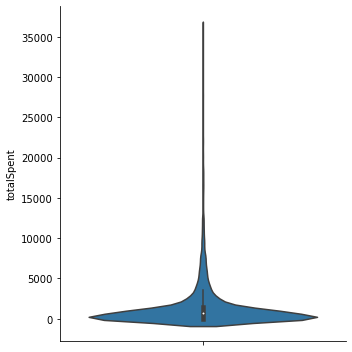

In [24]:
sns.catplot(data=train_data, y="totalSpent",kind="violin")

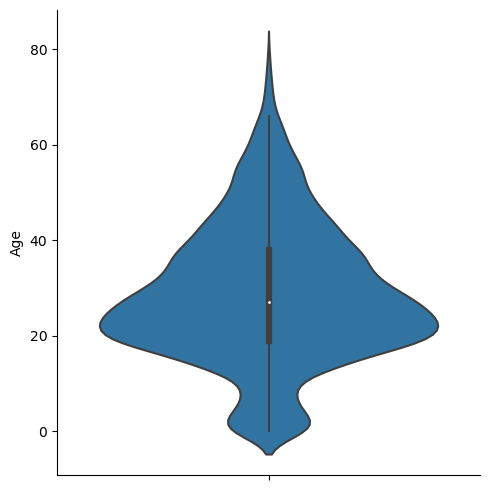

In [25]:
sns.catplot(data=train_data[["Age", "Transported"]], kind="violin", y="Age")

In [26]:
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


#num_cols = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "totalSpent"]
num_cols = ["Age", "totalSpent"]
cat_cols = ["HomePlanet", "Destination", "VIP", "Deck", "shipSide", "NumBin"]

In [27]:
Q1 = train_data[num_cols].quantile(0.01)
Q3 = train_data[num_cols].quantile(0.98)

IQR = Q3 - Q1

In [28]:
lower_lim = Q1 - 1.5 * IQR
upper_lim = Q3 + 1.5 * IQR

In [29]:
train_data.dropna(inplace=True)

In [30]:
X = train_data[num_cols + cat_cols]

In [31]:
y = train_data["Transported"]


In [32]:
num_transformer = Pipeline(
    [
        ("impute_num", SimpleImputer(strategy="mean")),
        ("scale", RobustScaler())

    ]
)

In [33]:
cat_transfomer = Pipeline(
    [
        ("impute_cat", SimpleImputer(strategy="most_frequent")),
        ("encode", OneHotEncoder())
    ]
)

In [34]:
colt_X = ColumnTransformer(
    transformers=[
       ("num", num_transformer, make_column_selector(dtype_include=np.number)),
       ("cat", cat_transfomer, make_column_selector(dtype_include=[object, "category"])),
    ], 
   remainder="passthrough"
)

In [35]:
X = colt_X.fit_transform(X)

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

## Models

In [46]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

clf = AdaBoostClassifier(n_estimators=100)

scores = cross_val_score(clf, X,y, cv=10)
scores.mean()

0.7192650187659869

In [38]:
from sklearn.ensemble import GradientBoostingClassifier


tt = GradientBoostingClassifier(n_estimators=100)

In [39]:
scores = cross_val_score(tt, X, y, cv=10)
scores.mean()

0.7376260030439945

In [40]:
from sklearn.svm import SVC

s = SVC().fit(X_train, y_train)

In [41]:
from sklearn.metrics import accuracy_score

s.score(X_test, y_test)

0.7607223476297968

In [42]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

b = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5,
                      max_features=0.5).fit(X_train, y_train)


In [43]:
b.score(X_test, y_test)

0.690744920993228

In [44]:
from sklearn.ensemble import RandomForestClassifier

r = RandomForestClassifier(n_estimators=20).fit(X_train, y_train)

In [45]:
r.score(X_test, y_test)

0.7172686230248307

In [ ]:
from 